In [1]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw 

palette = ['#F8766D', '#A3A500', '#00BF7D', '#00B0F6', '#E76BF3']

<Figure size 100x100 with 0 Axes>

In [2]:
fractions = [10, 25, 50, 75, 90]

pheno_fit_df = (
    pl.scan_parquet("data/pheno_summary.parquet")
    .rename({"rsq": "rsq_pheno", "r": "r_pheno"})
)
gwas_fit_df = (
    pl.scan_parquet("data/gwas_summary.parquet")
    .rename({"rsq": "rsq_gwas", "r": "r_gwas"})
)
enum = pl.Enum([str(x) for x in fractions])
summary_df = (
    pheno_fit_df
    .join(gwas_fit_df, on=["phenotype", "fraction"])
    .with_columns(
        pl.col("fraction").cast(enum),
        (pl.col("rsq_gwas").sign() * pl.col("rsq_gwas").abs().sqrt()).alias("r_gwas"),
    )
    .collect()
)
summary_df.head(2)

fraction,phenotype,r_pheno,rsq_pheno,r_gwas,rsq_gwas
enum,str,f64,f64,f64,f64
"""50""","""M45""",0.113367,0.012852,0.043819,0.00192
"""10""","""M72""",0.348385,0.121372,0.149632,0.02239


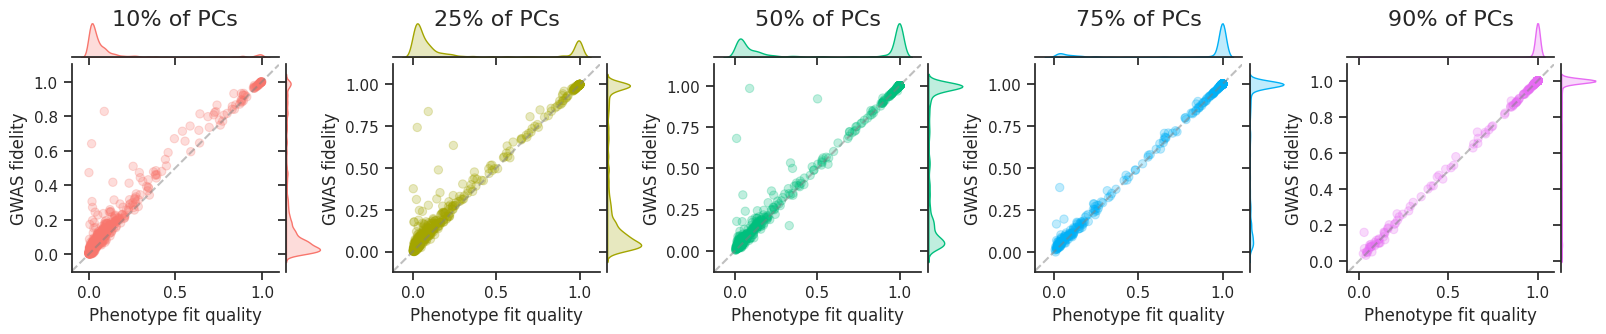

In [3]:
letters = list("ABCDE")
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = 'sans-serif'
sns.set_palette(palette)

pw.overwrite_axisgrid()
plots = list()
for i, fraction in enumerate(fractions):
    sns.set_style("ticks")
    sns.set_context("notebook")
    plot = (
        summary_df
        .filter(pl.col("fraction").eq(str(fraction)))
        .pipe(
            sns.jointplot, x="rsq_pheno", y="r_gwas", hue="fraction", alpha=0.25,
            height=2.5, edgecolors="face", linewidths=0.75, marginal_kws={'common_norm':False, "bw_adjust": 0.2},
        )
        .set_axis_labels(xlabel="Phenotype fit quality", ylabel="GWAS fidelity")
    )
    plot.ax_marg_x.text(s=f"{fraction}% of PCs", y=0.9, x=0.5, ha="center", transform=plot.ax_marg_x.transAxes, fontsize=16)
    # plot.ax_marg_x.text(s=letters[i], y=0.9, x=-0.25, ha="center", transform=plot.ax_marg_x.transAxes, fontsize="xx-large", fontweight="heavy")
    plt.legend([],[], frameon=False)
    plt.axline((0, 0), slope=1, linestyle="dashed", color="gray", alpha=0.5)
    plt.tight_layout()
    plot = pw.load_seaborngrid(plot, label=str(fraction))
    plots.append(plot)

result = pw.stack(plots, margin=0.)

result.savefig("img/distributions.png", facecolor="white", transparent=False)